In [2]:
import json

with open("attention_results/20240529_023233_attention_weights.json", "r") as file:
    attention_description = json.load(file)

    # Remove the 'attention_description' key if it exists
    if 'attention_description' in attention_description:
        del attention_description['attention_description']

    # Display the content of the JSON file nicely
    import pprint

    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(attention_description)


{   'all_tokens': [   'A',
                      'Ġchat',
                      'Ġbetween',
                      'Ġa',
                      'Ġcurious',
                      'Ġhuman',
                      'Ġand',
                      'Ġan',
                      'Ġartificial',
                      'Ġintelligence',
                      'Ġassistant',
                      '.',
                      'ĠThe',
                      'Ġassistant',
                      'Ġgives',
                      'Ġhelpful',
                      ',',
                      'Ġdetailed',
                      ',',
                      'Ġand',
                      'Ġpolite',
                      'Ġanswers',
                      'Ġto',
                      'Ġthe',
                      'Ġhuman',
                      "'s",
                      'Ġquestions',
                      '.',
                      '###',
                      'Human',
                      ':',
                      'Ġ',
  

In [3]:
# Print the length of all tokens
all_tokens = attention_description.get("all_tokens", [])
print(f"Length of all tokens: {len(all_tokens)}")


Length of all tokens: 870


In [4]:
import torch

# Load the attention results from the specified file
attention_results_path = "attention_results/main_attentions.pt"
attentions = torch.load(attention_results_path, map_location=torch.device('cpu'))

In [97]:
import numpy as np

decoder_no = 5
attention_matrices = []

for attention_head in range(32):
    final_size = attentions[-1][decoder_no][0, attention_head, :].shape[1]
    attention_matrix = np.zeros((final_size, final_size))

    first_matrix = np.array(attentions[0][decoder_no][0, attention_head, :])
    first_matrix_height = first_matrix.shape[0]

    # Insert the first_matrix into the top left corner of attention_matrix
    attention_matrix[:first_matrix.shape[0], :first_matrix.shape[1]] = first_matrix

    for generated_token_index, attention in enumerate(attentions[1:], start=0):
        new_token_row = np.array(attention[decoder_no][0, attention_head, :])
        new_token_row = np.pad(new_token_row, ((0, 0), (0, final_size - new_token_row.shape[1])), 'constant')

        attention_matrix[first_matrix_height + generated_token_index] = new_token_row

    attention_matrices.append(attention_matrix)

# Check if the first attention matrix (for attention head 0) is lower triangular
# is_lower_triangular = np.allclose(attention_matrices[0], np.tril(attention_matrices[0]))
# print(f"Is the attention matrix for head 0 a lower triangular matrix? {is_lower_triangular}")


In [98]:
output_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["output_tokens"]]
input_tokens = [token.replace('Ġ', '').replace('Ċ', '') for token in attention_description["input_tokens"]]


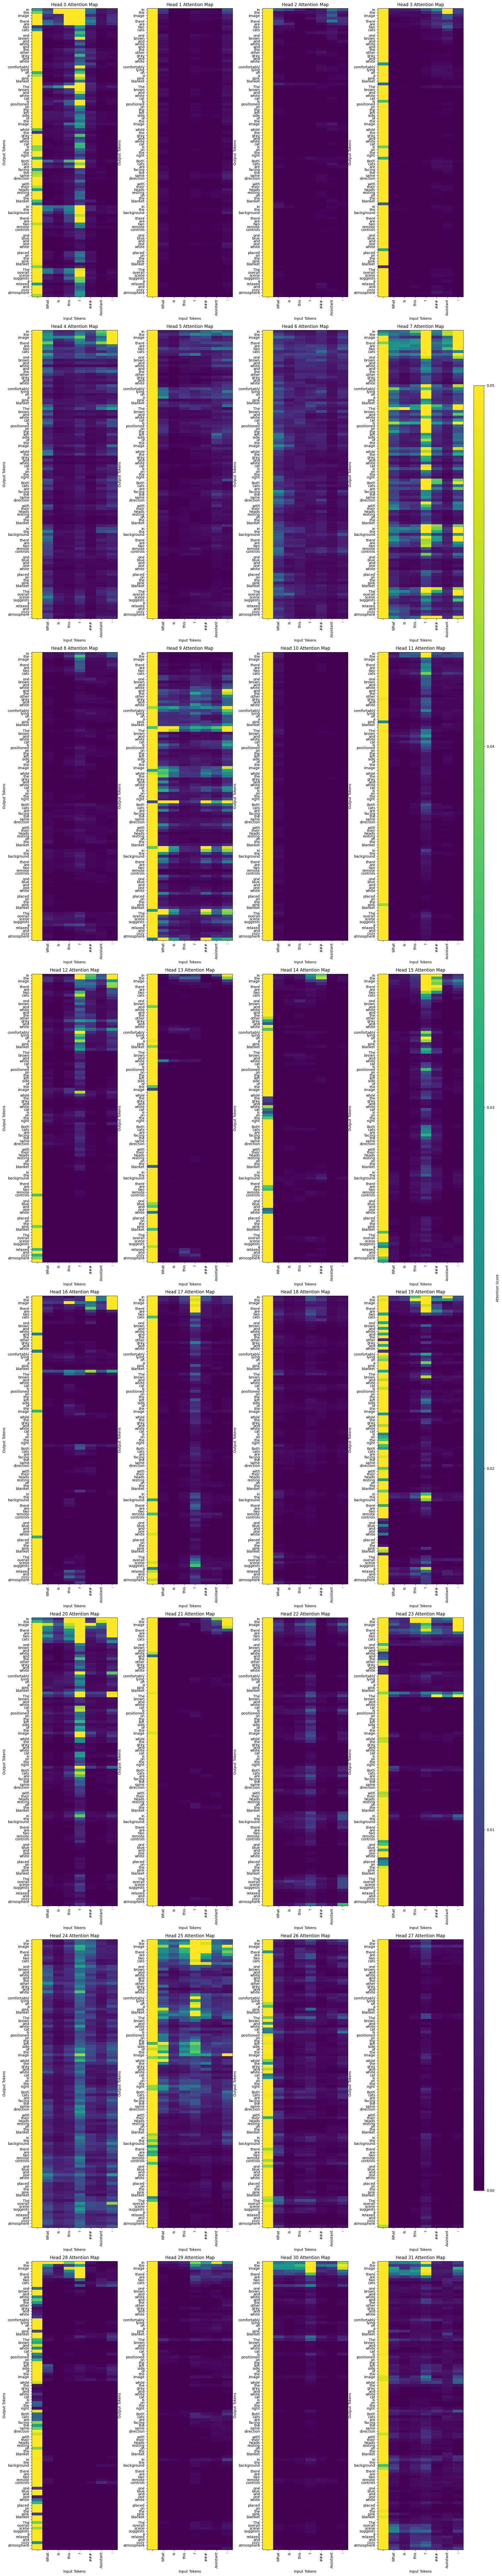

In [99]:
import matplotlib.pyplot as plt

image_token_indices = [i for i, token in enumerate(input_tokens) if token.startswith("image_")]
x_image_token_start = image_token_indices[0]
x_image_token_end = image_token_indices[-1] + 1

main_input_text = input_tokens[x_image_token_end:len(input_tokens)]

# Create a figure with a grid of subplots for all attention heads
fig, axes = plt.subplots(8, 4, figsize=(20, 100))  # 8 rows and 4 columns

for attention_head in range(32):
    # Filter the attention matrix to just the top len(output_tokens) rows, and the first x_image_token_start columns
    filtered_attention_matrix = attention_matrices[attention_head][-len(output_tokens):, x_image_token_end:len(input_tokens)]
    
    ax = axes[attention_head // 4, attention_head % 4]
    im = ax.imshow(filtered_attention_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=0.05)
    
    # Set the labels for the x and y axes using attention_description["all_tokens"]
    ax.set_xticks(np.arange(len(main_input_text)))
    ax.set_xticklabels(main_input_text, rotation=90)
    ax.set_yticks(np.arange(len(output_tokens)))
    ax.set_yticklabels(output_tokens)
    
    ax.set_ylabel('Output Tokens')
    ax.set_xlabel('Input Tokens')
    ax.set_title(f'Head {attention_head} Attention Map')

# Adjust layout and add a colorbar
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Attention Score')

plt.show()


In [100]:
# Print the whole output first
from textwrap import fill

wrapped_output = fill(attention_description["outputs"], width=80)
print(wrapped_output)
print("\n")
# Print a mapping of output_tokens and respective idx
for idx, token in enumerate(output_tokens):
    print(f"Index: {idx}, Token: {token}")



In the image, there are two cats, one brown and white and the other gray and
white, comfortably lying on a pink blanket. The brown and white cat is
positioned on the left side of the image, while the gray and white cat is on the
right. Both cats are facing the same direction, with their heads resting on the
blanket. In the background, there are two remote controls, one blue and one
white, placed on the pink blanket. The overall scene suggests a relaxed and cozy
atmosphere.


Index: 0, Token: In
Index: 1, Token: the
Index: 2, Token: image
Index: 3, Token: ,
Index: 4, Token: there
Index: 5, Token: are
Index: 6, Token: two
Index: 7, Token: cats
Index: 8, Token: ,
Index: 9, Token: one
Index: 10, Token: brown
Index: 11, Token: and
Index: 12, Token: white
Index: 13, Token: and
Index: 14, Token: the
Index: 15, Token: other
Index: 16, Token: gray
Index: 17, Token: and
Index: 18, Token: white
Index: 19, Token: ,
Index: 20, Token: comfortably
Index: 21, Token: lying
Index: 22, Token: on
Index: 2

cats


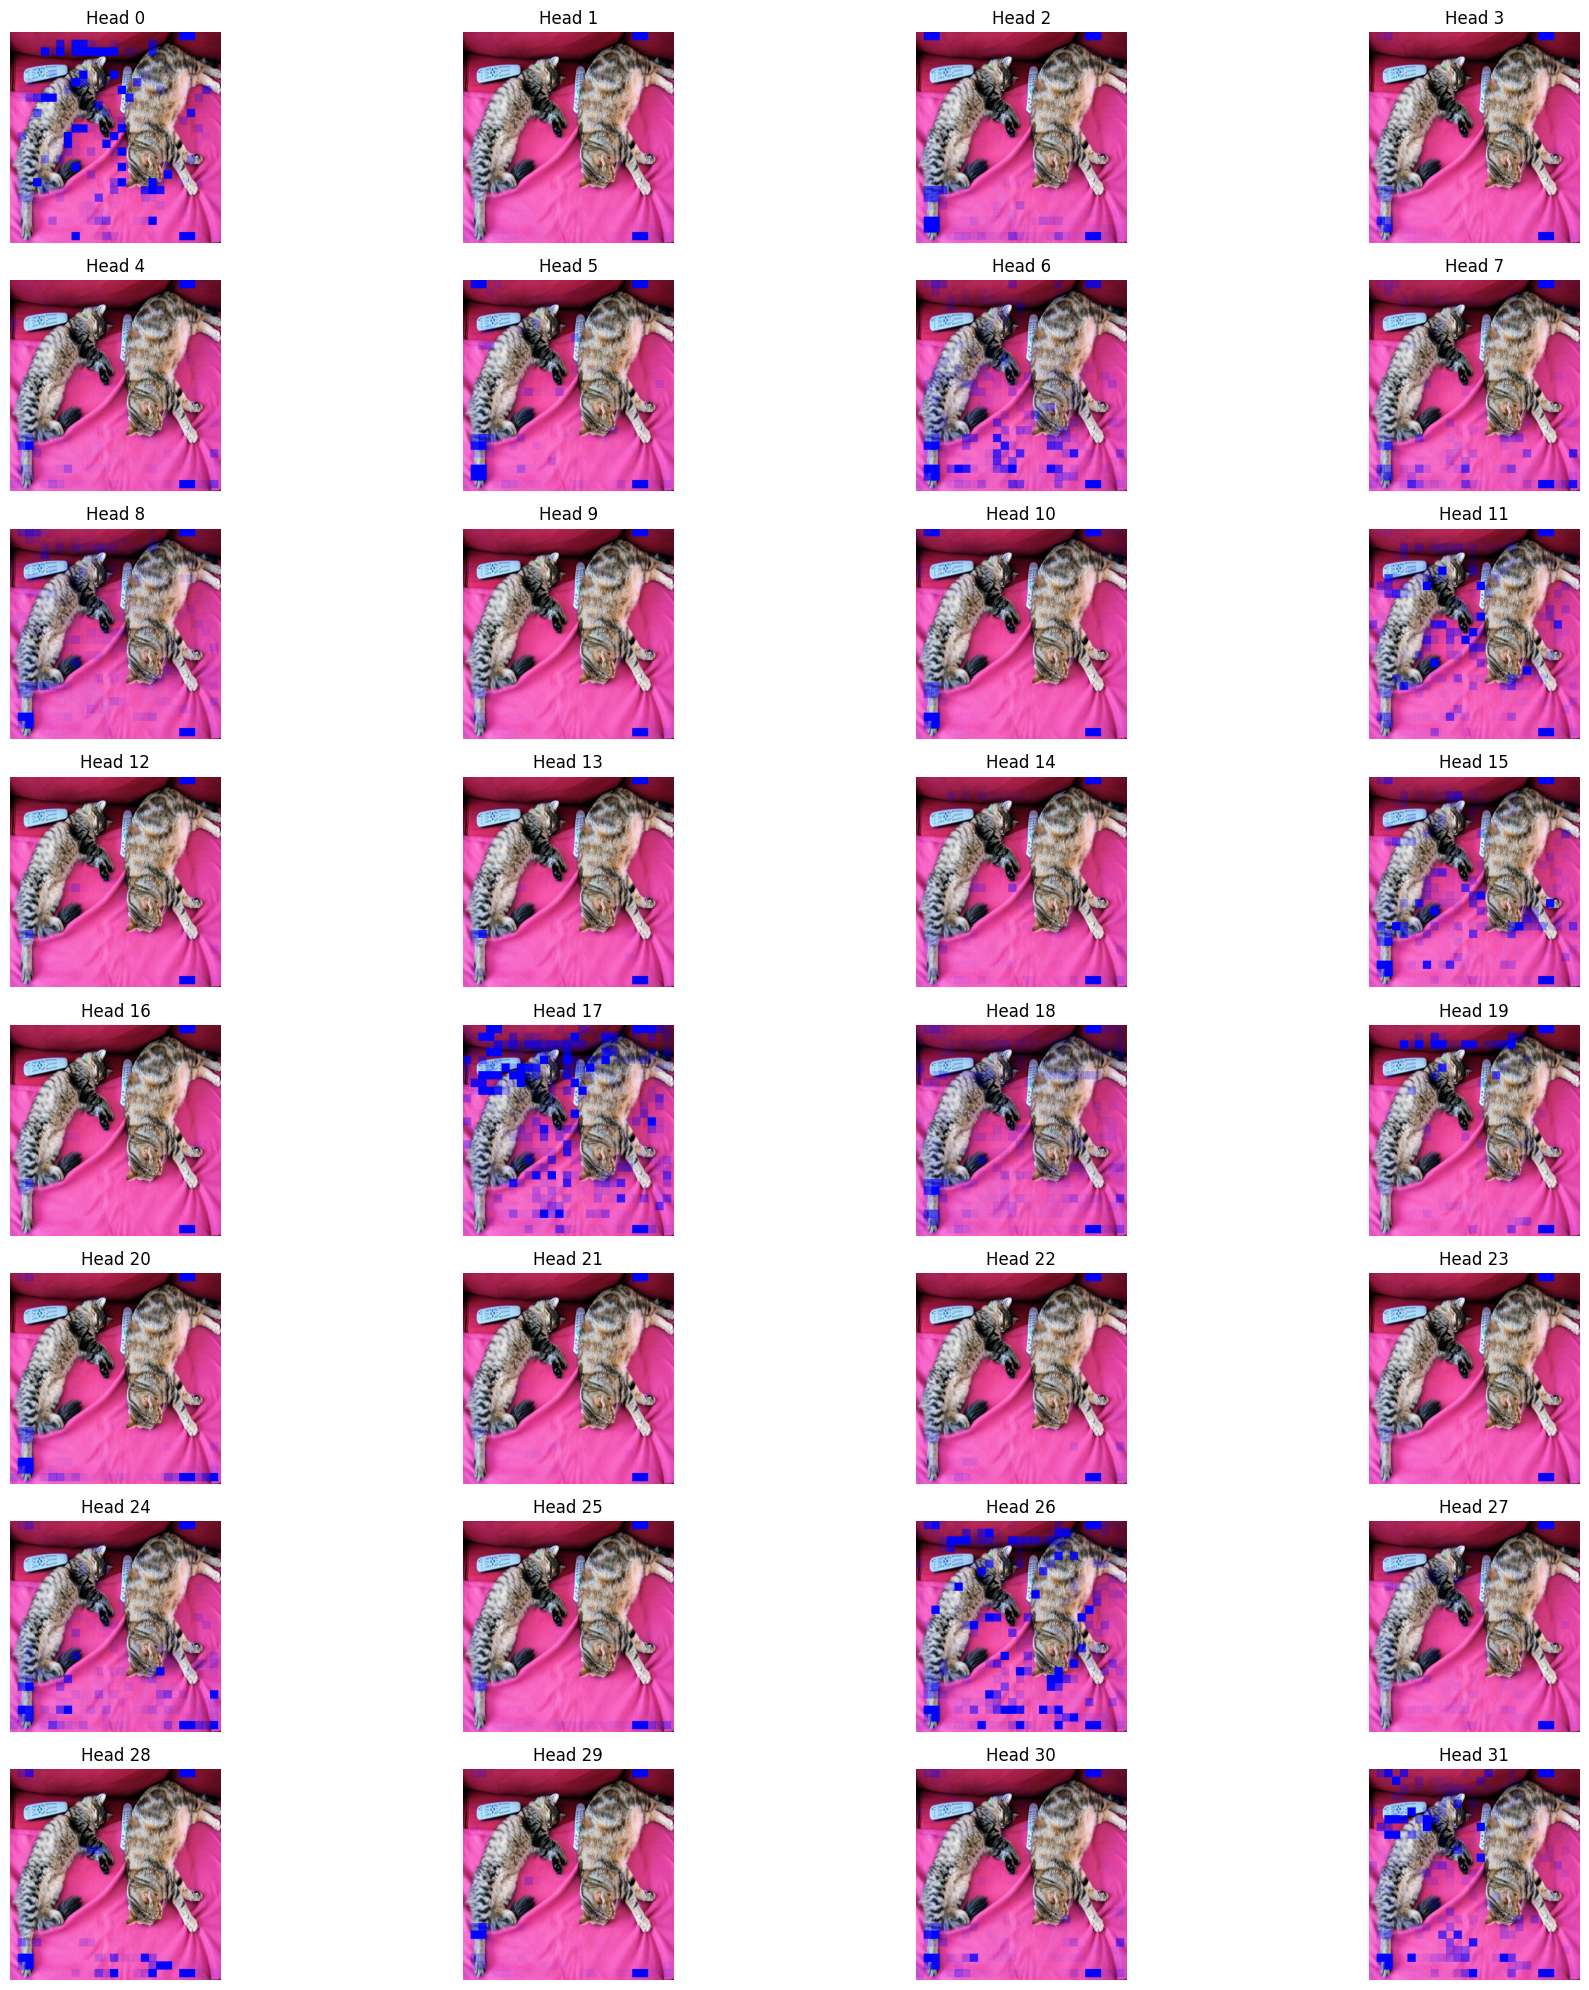

In [101]:
import requests
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Load the image from the URL
idx = 7  # 0 = the first token in the output
print(output_tokens[idx])
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Scale the image to 384 x 384
scaled_image = image.resize((384, 384))

# Create 27 x 27 patches
patch_size = 384 // 27

# Create a figure with a grid of subplots for all attention heads
fig, axes = plt.subplots(8, 4, figsize=(20, 20))  # 8 rows and 4 columns

for attention_head in range(32):
    output_row = attention_matrices[attention_head][len(input_tokens) + idx, :]

    # Get the columns in the matrix (xlim_start, xlim_end) for the 7th row
    image_patches = output_row[x_image_token_start:x_image_token_end]
    # Ensure selected_columns is reshaped to 27x27
    image_patches_reshaped = np.reshape(image_patches, (27, 27))

    # Create a new image to draw patches on
    patched_image = scaled_image.copy()
    draw = ImageDraw.Draw(patched_image, "RGBA")

    for i in range(27):
        for j in range(27):
            x0 = j * patch_size
            y0 = i * patch_size
            x1 = x0 + patch_size
            y1 = y0 + patch_size
            # Normalize the opacity to be between 0 and 1
            opacity = image_patches_reshaped[i, j] / 0.005
            draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 255, int(255 * opacity)))

    # Display the patched image in the corresponding subplot
    ax = axes[attention_head // 4, attention_head % 4]
    ax.imshow(patched_image)
    ax.axis('off')
    ax.set_title(f'Head {attention_head}')

# Adjust layout
fig.tight_layout()
plt.show()
